# Optimisation topologique linéaire

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import CSG2d, Circle, Rectangle
from copy import copy
import numpy as np
import matplotlib.pyplot as plt

importing NGSolve-6.2.2105-9-g5a835126f


## 1) Définition du maillage

In [2]:
def generate_fitted_circle_mesh(N):
    geo = CSG2d()
    R=1
    x = R*2*(np.append(np.insert(np.arange(0.5,N+0.5),0,0),N)/N-0.5)
    
    circle1 = Circle( center=(0,0), radius=R, bc="left_up" ) * Rectangle( pmin=(-R,0), pmax=(0,R))
    circle2 = Circle( center=(0,0), radius=R, bc="left_bot" ) * Rectangle( pmin=(-R,-R), pmax=(0,0))
    circle3 = Circle( center=(0,0), radius=R, bc="right_bot" ) * Rectangle( pmin=(0,-R), pmax=(R,0))
    circle4 = Circle( center=(0,0), radius=R, bc="right_up" ) * Rectangle( pmin=(0,0), pmax=(R,R))
    
    materials = ["iron","air"]
    
    for i in range(len(x)-1):
        geo.Add(Rectangle( pmin=(x[i],-R), pmax=(x[i+1],R), mat = materials[i%2] ) * (circle1 + circle2 + circle3 +circle4))

    #m = geo.GenerateMesh(maxh=max([R/N,1/30])) # On doit fixer la taille du maillage sinon le volume change à cause des elts grossiers
    m = geo.GenerateMesh(maxh=1/N)
    return Mesh(m)

#Draw (mesh)

## 2) Définition des problèmes éléments finis

In [3]:
beta = 1;

def solvePb(mu,mesh):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    K = BilinearForm(fespace_H1, symmetric=True)
    K +=  InnerProduct(grad(psi),mu*grad(phi))*dx

    n= specialcf.normal(mesh.dim);
    
    l1 = LinearForm(fespace_H1)
    l1 += -psi* beta * sqrt(1-x*x)* ds(definedon=mesh.Boundaries("right_bot|left_bot"))
    l1 += psi*beta* sqrt(1-x*x)*ds(definedon=mesh.Boundaries("right_up|left_up"))

    l2 = LinearForm(fespace_H1)
    l2 += -psi*beta*sqrt(1-y*y)*ds(definedon=mesh.Boundaries("right_bot|right_up"))
    l2 += psi*beta*sqrt(1-y*y)*ds(definedon=mesh.Boundaries("left_bot|left_up"))
    
    K.Assemble()
    l1.Assemble()
    l2.Assemble()
    
    phi1 = GridFunction(fespace_H1)  # solution
    phi1.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l1.vec
    phi2 = GridFunction(fespace_H1)  # solution
    phi2.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l2.vec
    
    return(phi1, phi2)

## 3) Optimisation

Le problème est auto-adjoint. Ainsi, l'adjoint s'écrit $\psi = -\phi$ et l'identification $\mathcal{L}^2$ du gradient par rapport à $\mu$ s'écrit:
$$\partial_\mu \mathcal{L} = -\int_\Omega |\nabla \phi|^2 $$

In [4]:
def gradient(phi1,phi2):
    return(-grad(phi1)*grad(phi1) + grad(phi2)*grad(phi2))

def compliance(phi,mu,mesh):
    return Integrate(grad(phi)*mu* grad(phi), mesh) /2

In [5]:
#mur = [2,10,100,1000]
mur = [2000]
mu0 = 4e-7*3.14
Nmesh = 40;
resultMU= []
resultJ = []
resultJpar = []
resultJser = []
resultVolFrac = []

for j in range(len(mur)):
    mesh = generate_fitted_circle_mesh(Nmesh)
    fespace_mu = L2(mesh, order=0)    
    mu = GridFunction(fespace_mu)
    mu.Set(mur[j]/2*mu0)
    mu_max = mur[j]*mu0
    J=[]
    step = (mu_max-mu0)/10
    g = GridFunction(fespace_mu)
    MU=[]
    Jpar = []
    Jser = []
    volFrac = []
    strt = '.'
    for i in range(1000):
        phi1, phi2 = solvePb(mu,mesh)
        g.Set(gradient(phi1,phi2))
        g.vec[:]= np.sign(g.vec[:].FV().NumPy())
        Jpar.append(compliance(phi1,mu,mesh))
        Jser.append(compliance(phi2,mu,mesh))
        J.append(compliance(phi1,mu,mesh) - compliance(phi2,mu,mesh))
        MU.append(copy(mu))
        volFrac.append(Integrate((mu-mu0)*dx,mesh) /(np.pi*(mur[0]*mu0-mu0)))
        
        if i>0 and J[-1]< J[-2]:
            step = min([step*1.2,mu_max-mu0])
        elif i>0:
            step = step/2
        
        mu.Set(MU[i] - g*step)
        mu.vec[:].FV().NumPy()[mu.vec[:].FV().NumPy()<mu0]=mu0
        mu.vec[:].FV().NumPy()[mu.vec[:].FV().NumPy()>mu_max]=mu_max
        if np.isnan(np.sum(mu.vec[:].FV().NumPy())):
            break
        if step/(mu_max-mu0) < 1e-6:
            break
        print(f'{J[-1]}', end = '\r')
        strt = strt+'.'
    print(f'{J[-1]} - mu_r = {mur[j]}')
    resultMU.append(copy(MU[-2]))
    resultJ.append(copy(J[-2]))
    resultJpar.append(copy(Jpar[-2]))
    resultJser.append(copy(Jser[-2]))
    resultVolFrac.append(copy(volFrac[-2]))

-740821.0162879885 - mu_r = 2000


In [6]:
Draw(resultMU[0],mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

In [7]:
print(resultVolFrac)

[0.26865006974411976]


In [8]:
print(resultJpar)

[50380.98083618559]


In [9]:
print(resultJser)

[791201.9284558222]


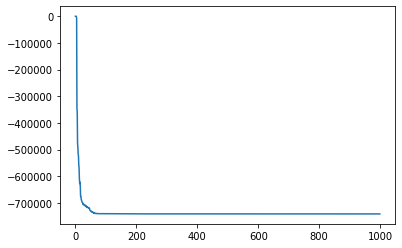

In [10]:
plt.plot(J)